# Final model

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RepeatedKFold, RepeatedStratifiedKFold
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import utils.mining_data_tb as md
import utils.visualization_tb as vi
import utils.models_tb as mo


import warnings

warnings.filterwarnings("ignore")

## Loading and preprocessing data

In [2]:
#### Load data
data_path = "data/hospital_train.csv"
variables_path = "data/columns_meaning.csv"

df = md.load_data(data_path, variables_path)

#### Preprocessing of categorical variables, as saw in 0_analysis file
# Preprocessor object
preprocessor = md.preprocessor()

# Process dummies
df = preprocessor.dummies(df)

# Map to process ordinal variables
to_map = ["Admission Type registered by the Hospital", "Severity of the illness recorded at the time of admission", "Age of the patient", "Stay Days by the patient"]

# Process ordinal variables
df = preprocessor.ordinal_mapper(df, to_map)

# Let's fill the NaNs with the mode an we are ready to go
df.loc[:, "Condition of Bed in the Ward"] = df.loc[:, "Condition of Bed in the Ward"].fillna(df.loc[:, "Condition of Bed in the Ward"].mode()[0])
df.loc[:, "City Code for the patient"] = df.loc[:, "City Code for the patient"].fillna(df.loc[:, "City Code for the patient"].mode()[0])

In [4]:
seed = 42

# Scaler
st_scaler = StandardScaler()

# Independent variables
X = np.array(df.drop("Stay Days by the patient", axis = 1))
X_st_scaled = st_scaler.fit_transform(X)

# Dependent variable
y = np.array(df["Stay Days by the patient"])

## Model

In [5]:
# To train/test the models, I'll make use of a "modeller" class that will take care
# of all the steps and return the main metrics

# Model
model = LogisticRegression(max_iter = 1000, n_jobs = -1)
# Object definition
modeller = mo.modeller(model)

# Data and parameters to pass in to the modeller object
# Train/test data
X_train, X_test, y_train, y_test = train_test_split(X_st_scaled, y, test_size = .2, random_state = seed)
# Cross validation
kfold = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1)
# Data features
features = list(df.columns)


# Now we load the data into the model
modeller.load_data(X_train, X_test, y_train, y_test, features, kfold)

# Finally, we train the model (only in the training set and using cross validation)
modeller.trainer(verb = 2)


-- Model 1 --
-------------------------
>train score: 0.39009375
>validation score: 0.3884375
--------------------------------------------------
Set structure:
Train structure: {1: 0.074453125, 2: 0.243984375, 3: 0.273953125, 4: 0.172875, 5: 0.037234375, 6: 0.10990625, 7: 0.00875, 8: 0.0330625, 9: 0.014703125, 10: 0.009046875, 11: 0.02203125}
Validation structure: {1: 0.0744375, 2: 0.244, 3: 0.274, 4: 0.172875, 5: 0.0371875, 6: 0.109875, 7: 0.00875, 8: 0.0330625, 9: 0.0146875, 10: 0.0090625, 11: 0.0220625}
###########################################################################

-- Model 2 --
-------------------------
>train score: 0.390578125
>validation score: 0.383625
--------------------------------------------------
Set structure:
Train structure: {1: 0.074453125, 2: 0.243984375, 3: 0.273953125, 4: 0.172875, 5: 0.037234375, 6: 0.10990625, 7: 0.00875, 8: 0.0330625, 9: 0.014703125, 10: 0.009046875, 11: 0.02203125}
Validation structure: {1: 0.0744375, 2: 0.244, 3: 0.274, 4: 0.172

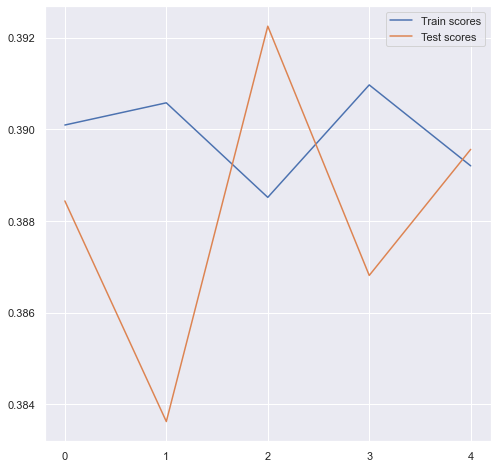

In [6]:
# Plotter object with useful methods
plotter = vi.plotter()

# To plot the cross validaiton progression
fig = plotter.train_val(modeller)

In [7]:
# Train the model with the full training set
modeller.tester(verb = 4)

-- Scores --
>Train score: 0.3896625
>Test score: 0.3906
--------------------------------------------------
--------------------------------------------------

-- Metrics --
Accuracy: None
Precision: 0.3906
Recall: 0.35688308494208715
F1 score: 0.3440637498045604
--------------------------------------------------

-- Confusion matrix --
[[  53  688  691   34    0    5    0    0    0    0    0]
 [  16 2271 2240  239    0  191    0    0    0    0    0]
 [   9 1605 3665  162    0   91    0    0    0    0    3]
 [   7  684 1460  656    0  659    0    0    0    0   15]
 [   5  157  419   52    0   53    0    0    0    0    4]
 [   3  205  349  612    0 1010    0    0    0    0   13]
 [   0   27   81   22    0   22    0    0    0    0    5]
 [   1   41   64  183    0  298    0    0    0    0   65]
 [   0   15   11   26    0  218    0    0    0    0   24]
 [   0   13   21   29    0   92    0    0    0    0   29]
 [   1   12   26   27    0  164    0    0    0    0  157]]
----------------------

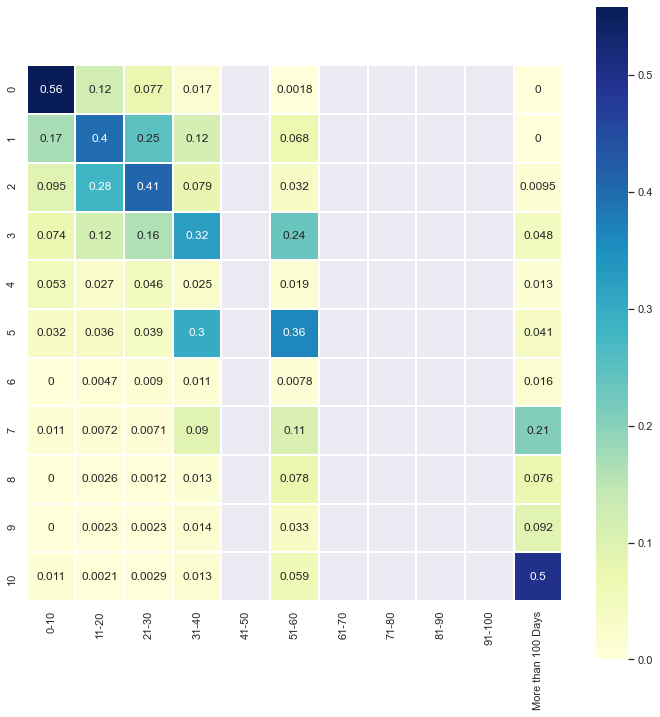

In [8]:
# Plot confusion matrix

preprocessor = md.preprocessor()
labels = preprocessor.target_variable()

fig = plotter.confusion_matrix(modeller, labels)

## Submission

For the submission, I have to load the test_data and preprocess it I did with the training one, so that predictions remain the same.

In [9]:
X_pred = pd.read_csv("data/hospital_test.csv")
X_pred.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,314114,19,a,7,Y,4,gynecology,S,C,2.0,59278,8.0,Emergency,Minor,2,41-50,4778.0
1,208989,15,c,5,Z,3,gynecology,S,F,2.0,102253,15.0,Trauma,Moderate,3,31-40,5734.0


I can see that it is the same structure but without the labels (target variable), since I have to predict that one and upload it.

In [10]:
X_pred = pd.read_csv("data/hospital_test.csv")
# Let's process this data

# 1) Rename the columns as the preprocessor is built based on column names and
# not indexes
column_names = pd.read_csv("data/columns_meaning.csv", index_col = 0)["Description"].values[:-1]
X_pred.columns = column_names

# Quick index reset
X_pred = X_pred.set_index("Case_ID registered in Hospital")
ids = X_pred.index  # Save the ids for submission

# 2) Dummies
X_pred = preprocessor.dummies(X_pred)

# 3) Ordinal variables
to_map = ["Admission Type registered by the Hospital", "Severity of the illness recorded at the time of admission", "Age of the patient"]
X_pred = preprocessor.ordinal_mapper(X_pred, to_map)

# 4) Filling NaNs
X_pred.loc[:, "Condition of Bed in the Ward"] = X_pred.loc[:, "Condition of Bed in the Ward"].fillna(X_pred.loc[:, "Condition of Bed in the Ward"].mode()[0])
X_pred.loc[:, "City Code for the patient"] = X_pred.loc[:, "City Code for the patient"].fillna(X_pred.loc[:, "City Code for the patient"].mode()[0])

# 5) Scaling data
#X_pred = np.array(X_pred)
X_pred_scaled = st_scaler.fit_transform(X_pred)

X_pred_scaled

array([[ 0.0812301 ,  0.68632661, -0.7110926 , ..., -0.44114869,
        -0.45958555, -0.73809243],
       [-0.38203043, -0.17029426, -0.7110926 , ..., -0.44114869,
        -0.45958555,  1.35484387],
       [-0.15040016,  0.68632661,  1.5795854 , ..., -0.44114869,
         2.17587344, -0.73809243],
       ...,
       [-0.2662153 , -0.17029426,  0.4342464 , ..., -0.44114869,
        -0.45958555, -0.73809243],
       [ 1.12356629,  0.68632661, -0.7110926 , ..., -0.44114869,
        -0.45958555,  1.35484387],
       [-1.42436662,  0.68632661, -0.7110926 , ..., -0.44114869,
        -0.45958555,  1.35484387]])

In [18]:
# Now that the data is ready, let's call our model to predict
predictions = modeller.model.predict(X_pred_scaled)
labels = preprocessor.target_variable()

labeled_predictions = [labels[prediction] for prediction in predictions]

to_submit = pd.DataFrame(list(zip(ids, labeled_predictions)), columns = ["id", "days"])
to_submit = to_submit.set_index("id")
to_submit

,days
id,
314114,11-20
208989,31-40
305872,11-20
266099,31-40
13228,21-30
...,...
318155,21-30
144850,11-20
180676,11-20


In [19]:
# Now I can save the submission
to_submit.to_csv("submissions/submission1.csv")